In [10]:

import numpy as np
import pandas as pd
import scipy
import scipy.io as sio
import scipy.sparse as sps
import sys
import os
from pathlib import Path
import itertools
import jax
from jax import random as jran
from jax import jit as jjit
from jax import value_and_grad
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)
from time import time
from jaxopt import ProjectedGradient
from jax import jit, grad


In [11]:
def flatten(t):
    return [item for sublist in t for item in sublist]   

# create directory to save files    
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise  

def extract_input_parameters(fpath):
    mat = sio.loadmat(fpath)
    F = []
    Y = []
    sigmaY = []
    modY = []
    for i in range(50):
        F.append(mat["F"][i][0].flatten())
        Y.append(mat["Ymr"][i][0].flatten())
        sigmaY.append(mat['sigma_Ymr'][i][0].flatten())
        modY.append(jnp.abs(mat["Ymr"][i][0].flatten()))
    V = mat['Vdr'].flatten()
    return(F,Y,sigmaY,modY, V)

def extract_input_parameters_Z(fpath):
    mat = sio.loadmat(fpath)
    F = []
    Z = []
    sigmaZ = []
    modZ = []
    for i in range(50):
        F.append(mat["F"][i][0].flatten())
        Z.append(mat["Zmr"][i][0].flatten())
        sigmaZ.append(mat['sigma_Zmr'][i][0].flatten())
        modZ.append(jnp.abs(mat["Zmr"][i][0].flatten()))
    V = mat['Vdr'].flatten()
    return(F,Z,sigmaZ, modZ,V)

def fun(p, x):  
    norder = int((len(p)-1)/2)
    a = jnp.array(p)[0:norder+1]
    b = jnp.concatenate([jnp.array(p)[norder+1:2*norder+1], jnp.array([1])], axis = 0)
    Ypa = jnp.polyval(a,jnp.sqrt(1j*x))/jnp.polyval(b,jnp.sqrt(1j*x))
    return jnp.concatenate([(Ypa).real, (Ypa).imag], axis = 0)


@jax.jit
def objfun(p, x, y, yerr):
    ndata = len(x)
    dof = (2*ndata-(len(p)))
    y_concat = jnp.concatenate([y.real, y.imag], axis = 0)
    sigma = jnp.concatenate([yerr,yerr], axis = 0)
    y_model = fun(p, x)
    # chi_sqr = ((jnp.abs((1/sigma**2) * (y_concat - y_model)**2)))
    chi_sqr = jnp.linalg.norm(((y_concat - y_model)/sigma))**2
    return (chi_sqr)

@jax.jit
def objfunls(p, x, y, yerr):
    ndata = len(x)
    dof = (2*ndata-(len(p)))
    y_concat = jnp.concatenate([y.real, y.imag], axis = 0)
    sigma = jnp.concatenate([yerr,yerr], axis = 0)
    y_model = fun(p, x)
    chi_sqr = ((jnp.abs((1/sigma) * (y_concat - y_model))))
    # chi_sqr = jnp.linalg.norm(((y_concat - y_model)/sigma))**2
    return (chi_sqr)



In [12]:
F, Y, sigma_Y, mod_Y, V = extract_input_parameters('data/nihcf')

order = 5
idx = 49
lb = jnp.full((2*order+1,),1e-15)
ub = jnp.full((2*order+1,),1e15)

# params_init = jnp.array([3.81387658e-03, 5.27673791e-01, 3.91863632e+00,
#              1.90296690e+00, 5.16802361e-07, 3.00596631e-10,
#              1.06711495e-07, 2.60232119e-03, 6.39913090e-02,
#              1.84099843e+01, 1.57518646e+02, 3.09630488e+02,
#              9.41887369e-01, 1.37663535e+02, 8.41032196e-02])
params_init = jnp.ones(order*2+1) 

n_par = len(params_init)
n_data = len(F)



Optimal parameters: [2.70302932e+04 4.76646227e+05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.20237416e+06 4.55645538e+05 6.24061321e+07
 6.93424239e+06 4.62705017e+05 1.53446142e+05]


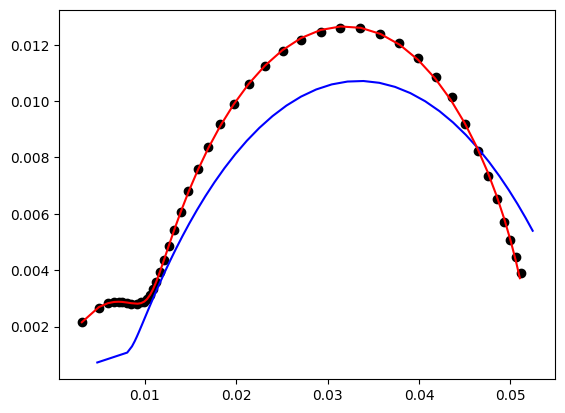

In [13]:
import jaxopt
from jaxopt.projection import projection_non_negative

# define objective function and its gradient


# Define the optimization method.
opt = ProjectedGradient(fun=jax.jit(objfun), 
                        projection=projection_non_negative, 
                        maxiter=5000, tol=1e-12)

# Run optimization.

state = opt.run(init_params=params_init, x=F[0], y=Y[0], yerr=sigma_Y[0])
solution = state.params

# print solution
print(f"Optimal parameters: {solution}")

y_pred_proj = fun(solution, F[idx])[:len(F[0])] + 1j*fun(solution, F[idx])[len(F[0]):]

res = scipy.optimize.least_squares(
            jax.jit(objfunls),
            solution,
            args=(F[idx], Y[idx], sigma_Y[idx]),
            method='lm',
            tr_solver='lsmr',
            jac=jax.jacobian(jax.jit(objfunls)),
            xtol=1e-12,
            )

# Extract solution
popt = res.x

Y_pred = fun(popt, F[idx])[:len(F[0])] + 1j*fun(popt, F[idx])[len(F[0]):]
import matplotlib.pyplot as plt
plt.plot(Y[idx].real, Y[idx].imag, 'o', color = 'black', label = 'data')
plt.plot(y_pred_proj.real, y_pred_proj.imag, '-', color = 'blue', label = 'proj')
plt.plot(Y_pred.real, Y_pred.imag, '-', color = 'red', label = 'ls')
plt.show()

In [14]:
# import numpy as np
# from scipy.signal import residue

# # assuming popt are your optimized parameters
# norder = int((len(popt)-1)/2)

# # get a and b coefficients from popt
# a = popt[0:norder+1]
# b = np.concatenate([popt[norder+1:2*norder+1], np.array([1])], axis = 0)

# # perform partial fraction decomposition
# residues, poles, _ = residue(a, b)
# print(poles)

# # compute time constants from poles
# time_constants = -1/poles.real

# print("Time constants:", time_constants)


In [15]:
# import vectfit
# import numpy as np

# # Convert your frequencies and responses to numpy arrays
# F_np = 2*np.pi*np.array(F[idx])
# Y_np = np.array(Y_pred)

# # Prepare the frequencies for the Vector Fitting algorithm
# frequencies = 2j * np.pi * F_np

# # Convert the frequency-response data to the s-domain
# s = frequencies
# f = Y_np

# # Run the Vector Fitting algorithm, automatically determining the number of poles
# poles, residues, d, h = vectfit.vectfit_auto_rescale(f, s, n_poles=5)

# # Compute the time constants
# time_constants = -1 / poles.real

# print('Time constants:', time_constants)

In [16]:
# Yes, essentially, you have performed a partial fraction decomposition using the Vector Fitting algorithm.

# The Vector Fitting method is essentially a rational function approximation method that represents a given frequency-domain system response as a ratio of two polynomials.

# This can be seen as a generalization of partial fraction decomposition, where you decompose a rational function into simpler parts, usually sum of fractions with simpler denominators. In the case of system responses in control theory or signal processing, these simpler fractions often have a physical interpretation in terms of system poles and residues.

# The poles of the system often correspond to system's natural frequencies, the roots of the polynomial in the denominator of your rational function. These roots, when they are real, are inversely proportional to the time constants of the system.

# The residues correspond to the coefficients of these simpler fractions and give you information about the contribution of each natural frequency to the overall system response.

# The constants d and h correspond to the offset and slope of the approximated function, respectively.

# Yes, the Vector Fitting algorithm is generally set up to provide real poles for system approximations. This is because in many physical systems, especially those that are stable and passive (like many electrical networks), the poles of the system's transfer function are either real or come in complex conjugate pairs. When dealing with such systems, it's often most interpretable to work with real poles.

# The poles you get from scipy's methods can be complex because those methods are general purpose root-finding algorithms. They're meant to find the roots of any polynomial, not just those that come from physical system models.

# If you're getting complex poles from scipy's methods but not from the Vector Fitting method, there could be a few different things going on:

# It could be that the model you're fitting to your data doesn't quite represent the physics of the system you're studying. In this case, the complex poles might be trying to compensate for parts of the data that the model can't fit well.

# It could be that there's noise or other errors in your data that's causing the fitting methods to find a slightly incorrect model.

# It could also just be a numerical artifact of the fitting methods. Sometimes, due to numerical errors, root-finding algorithms can find roots that are very slightly off the real line, even when all the "true" roots are real.

# To interpret the results, it is important to consider the physical meaning of the parameters and the nature of the system being studied. If the system is known to be stable and passive, complex poles might be a sign that the model or the data need to be revised.